In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.optimizers import adam_v2
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

import cv2
from cv2 import imread, createCLAHE # read and equalize images

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from skimage.util import montage as montage2d

import os
from glob import glob
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
!mkdir /home/TBX11K/Segmented

!mkdir /home/TBX11K/Segmented/train
!mkdir /home/TBX11K/Segmented/val
!mkdir /home/TBX11K/Segmented/test

!mkdir /home/TBX11K/Segmented/train/sick
!mkdir /home/TBX11K/Segmented/train/health
!mkdir /home/TBX11K/Segmented/train/tb

!mkdir /home/TBX11K/Segmented/val/sick
!mkdir /home/TBX11K/Segmented/val/health
!mkdir /home/TBX11K/Segmented/val/tb


!mkdir /home/TBX11K/Segmented/test/Montgomery
!mkdir /home/TBX11K/Segmented/test/Montgomery/health
!mkdir /home/TBX11K/Segmented/test/Montgomery/tb
!mkdir /home/TBX11K/Segmented/test/Montgomery/sick

!mkdir /home/TBX11K/Segmented/test/Shenzhen
!mkdir /home/TBX11K/Segmented/test/Shenzhen/health
!mkdir /home/TBX11K/Segmented/test/Shenzhen/tb
!mkdir /home/TBX11K/Segmented/test/Shenzhen/sick

!mkdir /home/TBX11K/Segmented/test/TBX11
!mkdir /home/TBX11K/Segmented/test/TBX11/health
!mkdir /home/TBX11K/Segmented/test/TBX11/tb
!mkdir /home/TBX11K/Segmented/test/TBX11/sick

In [3]:
from multiprocessing import Pool
DILATE_KERNEL = np.ones((12, 12), np.uint8)

MASK_DIR = '/home/TBX11K/masks'

def getMaskFilename(basename):

    mask_file = os.path.join(MASK_DIR,basename)
    if os.path.exists(mask_file):
        return mask_file
    else:
        return ""
    
def findMaskFile(filename):
    basename = os.path.basename(filename)
    if "oversampled" in basename:
        parts = basename.split('_')
        org_parts = parts[2:]
        original_img = "_".join(org_parts)
        
        mask_img = getMaskFilename(original_img)
        if mask_img=="":
            print(original_img)
    else:
        mask_img = getMaskFilename(basename)
    return mask_img

def process_segmented(res):
    filename = res['filename']
    mask_file = res['mask_file']
    dest_file = res['dest_file']
    
    image = cv2.imread(filename)
    mask_image = cv2.imread(mask_file,cv2.IMREAD_GRAYSCALE)
    mask_image = cv2.resize(mask_image,(224,224))
    mask_dilate = cv2.dilate(mask_image, DILATE_KERNEL, iterations=2)
    image[mask_dilate==0] = 0
    cv2.imwrite(dest_file,image)
    return True


def process_image_files(img_files,dest_dir):
    res = []
    for filename in img_files:
        dest_file = os.path.join(dest_dir,os.path.basename(filename))
        row = {'filename':filename,'dest_file':dest_file}
        res.append(row)
    
    workers = os.cpu_count()
    with Pool(workers) as p:
        p.map(process_segmented, res)  

In [4]:
TBX_DIR = '/home/TBX11K/MergedBCH'
TBX_DEST_DIR = '/home/TBX11K/Segmented'
for split_dir in ['train','val']:
    for class_dir in ['health','sick','tb']:
        file_path = os.path.join(TBX_DIR,split_dir,class_dir,'*.png')
        img_files = glob(file_path)
        dest_dir = os.path.join(TBX_DEST_DIR,split_dir,class_dir)
        
        res = []
        for filename in img_files:
            mask_file = findMaskFile(filename)
            basename = os.path.basename(filename)
            dest_file = os.path.join(dest_dir,basename)
            if mask_file!="":
                row = {'filename': filename,'mask_file':mask_file,'dest_file':dest_file}
                res.append(row)
        
        workers = os.cpu_count()
        with Pool(workers) as p:
            p.map(process_segmented, res)

In [25]:
TBX_DIR_TEST = '/home/TBX11K/MergedBCH/test'
TBX_DEST_DIR_TEST = '/home/TBX11K/Segmented/test'
for split_dir in ['Montgomery','Shenzhen','TBX11']:
    for class_dir in ['health','sick','tb']:
        file_path = os.path.join(TBX_DIR_TEST,split_dir,class_dir,'*.png')
        img_files = glob(file_path)
        dest_dir = os.path.join(TBX_DEST_DIR_TEST,split_dir,class_dir)
        
        res = []
        for filename in img_files:
            mask_file = findMaskFile(filename)
            basename = os.path.basename(filename)
            dest_file = os.path.join(dest_dir,basename)
            if mask_file!="":
                row = {'filename': filename,'mask_file':mask_file,'dest_file':dest_file}
                res.append(row)
        
        workers = os.cpu_count()
        with Pool(workers) as p:
            p.map(process_segmented, res)

In [15]:
def segImage(img_name):
    basename = os.path.basename(img_name)
    mask_file = os.path.join('/home/TBX11K/masks',basename)
    mask_image = cv2.imread(mask_file,cv2.IMREAD_GRAYSCALE)
    mask_image = cv2.resize(mask_image,(224,224))
    #mask_dilate = cv2.dilate(mask_image, DILATE_KERNEL, iterations=2)
    image = cv2.imread(img_name)
    image[mask_image==0] = 0
    return image

def dilateImage(img_name):
    basename = os.path.basename(img_name)
    mask_file = os.path.join('/home/TBX11K/masks',basename)
    mask_image = cv2.imread(mask_file,cv2.IMREAD_GRAYSCALE)
    mask_image = cv2.resize(mask_image,(224,224))
    mask_dilate = cv2.dilate(mask_image, DILATE_KERNEL, iterations=2)
    image = cv2.imread(img_name)
    image[mask_dilate==0] = 0
    return image

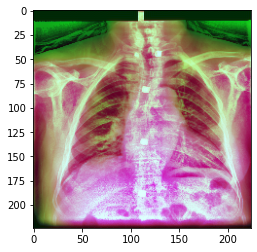

In [4]:
img = cv2.imread('/home/TBX11K/MergedBCH/train/sick/s1504.png')
plt.imshow(img)

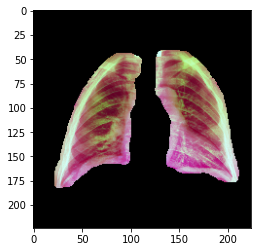

In [12]:
img = segImage('/home/TBX11K/MergedBCH/train/sick/s1504.png')
plt.imshow(img)

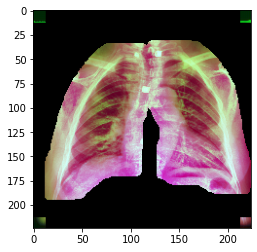

In [5]:
img = cv2.imread('/home/TBX11K/Segmented/train/sick/s1504.png')
plt.imshow(img)

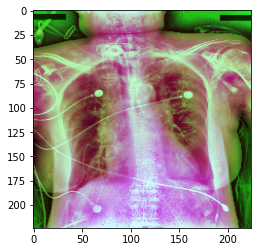

In [7]:
img = cv2.imread('/home/TBX11K/MergedBCH/test/TBX11/sick/s1835.png')
plt.imshow(img)

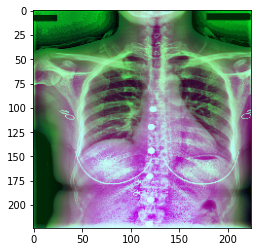

In [9]:
img = cv2.imread('/home/TBX11K/MergedBCH/train/sick/s1341.png')
plt.imshow(img)

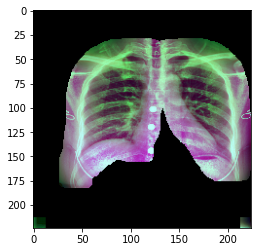

In [9]:
img = cv2.imread('/home/TBX11K/Segmented/train/sick/s1341.png')
plt.imshow(img)

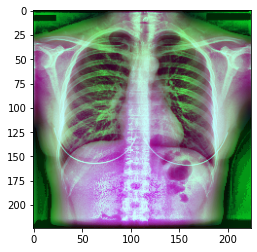

In [10]:
img = cv2.imread('/home/TBX11K/MergedBCH/train/sick/s2733.png')
plt.imshow(img)

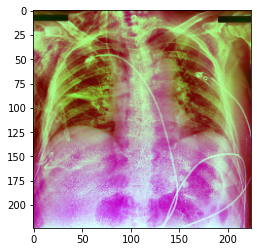

In [16]:
img = cv2.imread('/home/TBX11K/MergedBCH/train/sick/s3008.png')
plt.imshow(img)

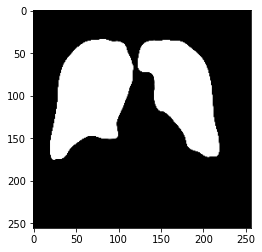

In [17]:
#s1835,s2093,s2449,s2671,s2733,s3008,s1504,s1341
img = cv2.imread('/home/TBX11K/masks/s2449.png')
plt.imshow(img)

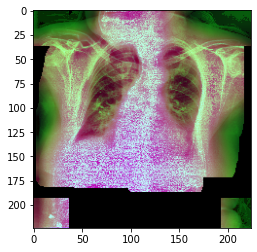

In [18]:
#s1835,s2093,s2449,s2671,s2733,s3008,s1504,s1341
img = cv2.imread('/home/TBX11K/Segmented/train/sick/s2093.png')
plt.imshow(img)

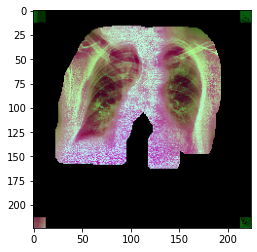

In [10]:
img = cv2.imread('/home/TBX11K/Segmented/train/sick/s2093.png')
plt.imshow(img)

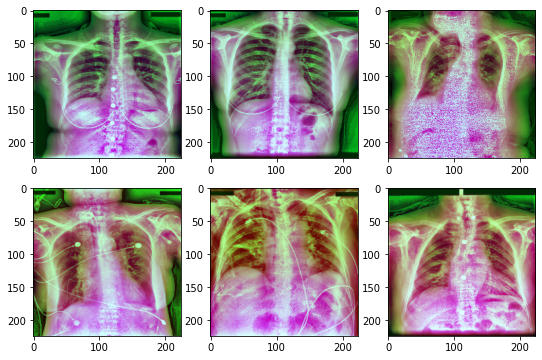

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(9,6))
im1 = cv2.imread('/home/TBX11K/MergedBCH/train/sick/s1341.png')
axs[0, 0].imshow(im1)

im2 = cv2.imread('/home/TBX11K/MergedBCH/train/sick/s2733.png')
axs[0, 1].imshow(im2)

im3 = cv2.imread('/home/TBX11K/MergedBCH/train/sick/s2093.png')
axs[0, 2].imshow(im3)

im4 = cv2.imread('/home/TBX11K/MergedBCH/test/TBX11/sick/s1835.png')
axs[1, 0].imshow(im4)

im5 = cv2.imread('/home/TBX11K/MergedBCH/train/sick/s3008.png')
axs[1, 1].imshow(im5)

im5 = cv2.imread('/home/TBX11K/MergedBCH/train/sick/s1504.png')
axs[1, 2].imshow(im5)
plt.show()

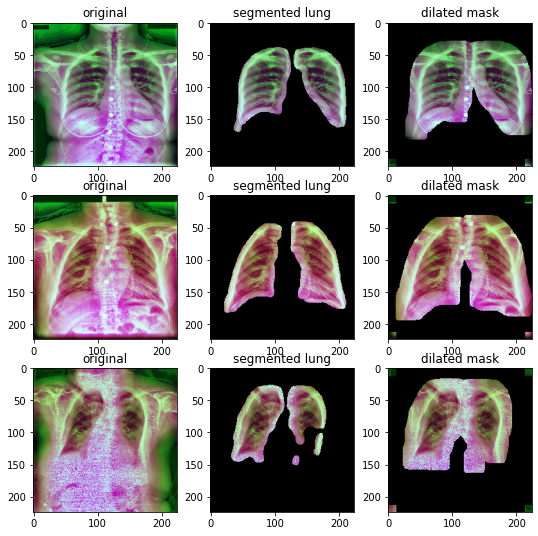

In [23]:
fig, axs = plt.subplots(3, 3, figsize=(9,9))
im1 = cv2.imread('/home/TBX11K/MergedBCH/train/sick/s1341.png')
axs[0, 0].imshow(im1)
axs[0, 0].set_title('original')

im4 = segImage('/home/TBX11K/MergedBCH/train/sick/s1341.png')
axs[0, 1].imshow(im4)
axs[0, 1].set_title('segmented lung')

im7 = dilateImage('/home/TBX11K/MergedBCH/train/sick/s1341.png')
axs[0, 2].imshow(im7)
axs[0, 2].set_title('dilated mask')

im2 = cv2.imread('/home/TBX11K/MergedBCH/train/sick/s1504.png')
axs[1, 0].imshow(im2)
axs[1, 0].set_title('original')

im5 = segImage('/home/TBX11K/MergedBCH/train/sick/s1504.png')
axs[1, 1].imshow(im5)
axs[1, 1].set_title('segmented lung')

im8 = dilateImage('/home/TBX11K/MergedBCH/train/sick/s1504.png')
axs[1, 2].imshow(im8)
axs[1, 2].set_title('dilated mask')


im3 = cv2.imread('/home/TBX11K/MergedBCH/train/sick/s2093.png')
axs[2, 0].imshow(im3)
axs[2, 0].set_title('original')


im6 = segImage('/home/TBX11K/MergedBCH/train/sick/s2093.png')
axs[2, 1].imshow(im6)
axs[2, 1].set_title('segmented lung')


im9 = dilateImage('/home/TBX11K/MergedBCH/train/sick/s2093.png')
axs[2, 2].imshow(im9)
axs[2, 2].set_title('dilated mask')

plt.show()

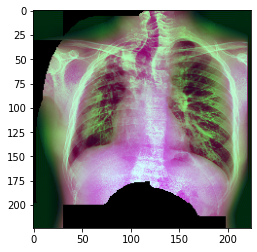

In [12]:
img = cv2.imread('/home/TBX11K/Segmented/val/tb/tb1031.png')
plt.imshow(img)

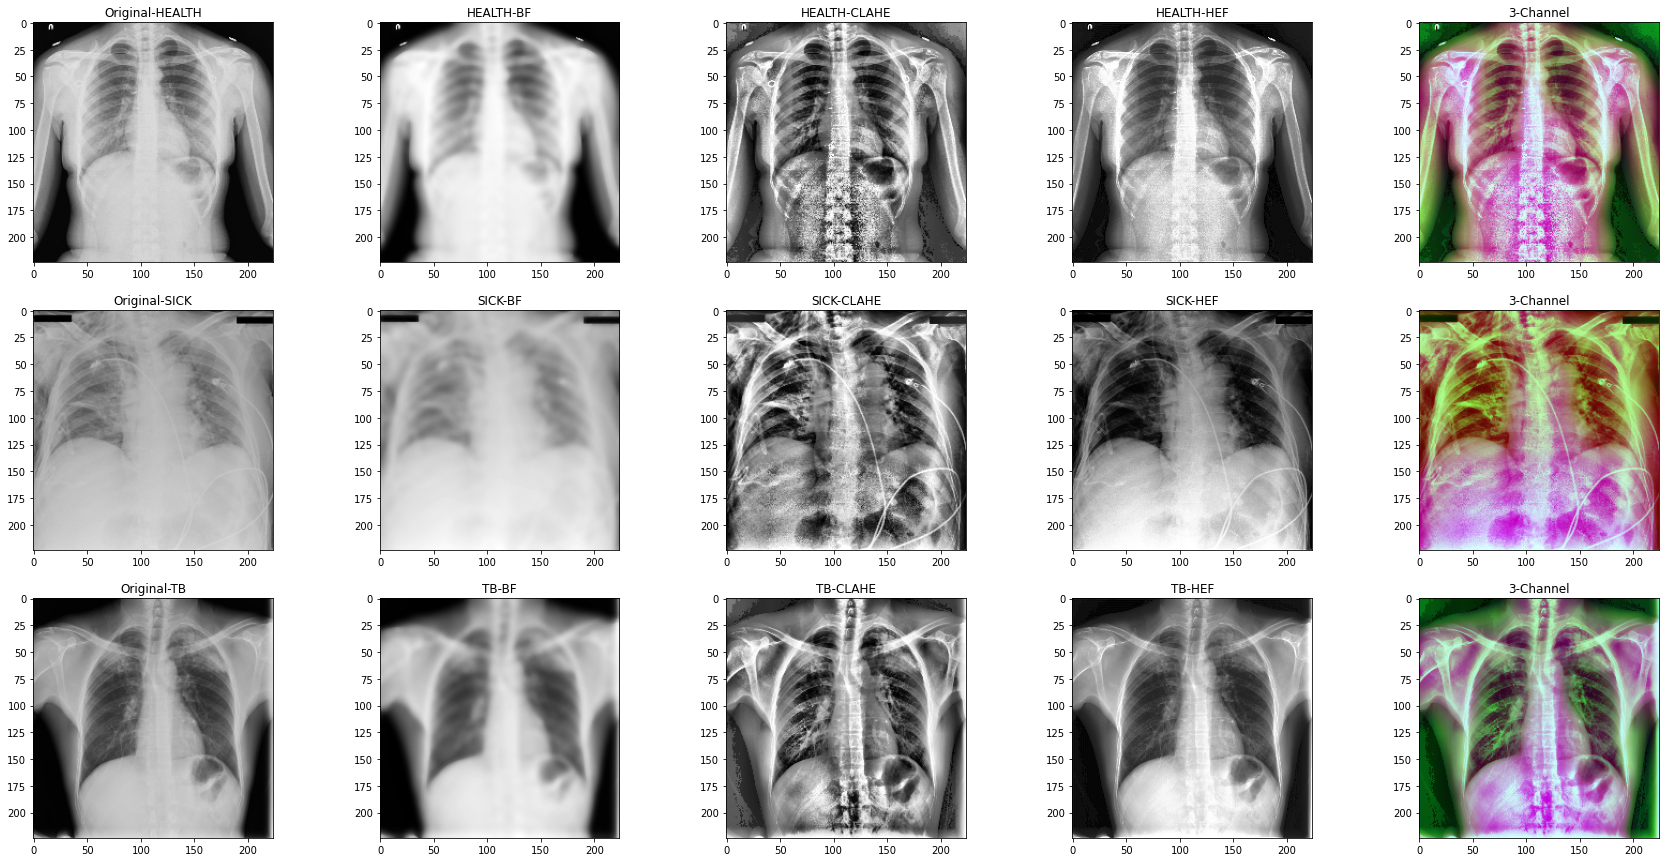

In [34]:
fig, axs = plt.subplots(3, 5, figsize=(30, 15))
health_img = '/home/TBX11K/MergedBCH/val/health/n1.png'
sick_img = '/home/TBX11K/MergedBCH/val/sick/s3008.png'
tb_img = '/home/TBX11K/MergedBCH/val/tb/tb1100.png'

og_health =  cv2.imread('/home/TBX11K/val/health/n1.png')
axs[0, 0].set_title('Original-HEALTH')
axs[0, 0].imshow(og_health,cmap='gray')

rgb_health = cv2.imread(health_img)
b,c,h = cv2.split(rgb_health)

axs[0, 1].set_title('HEALTH-BF')
axs[0, 1].imshow(b,cmap='gray')

axs[0, 2].set_title('HEALTH-CLAHE')
axs[0, 2].imshow(c,cmap='gray')

axs[0, 3].set_title('HEALTH-HEF')
axs[0, 3].imshow(h,cmap='gray')

axs[0, 4].set_title('3-Channel')
axs[0, 4].imshow(rgb_health)

og_sick =  cv2.imread('/home/TBX11K/val/sick/s3008.png')
axs[1, 0].set_title('Original-SICK')
axs[1, 0].imshow(og_sick,cmap='gray')

rgb_sick = cv2.imread(sick_img)
b,c,h = cv2.split(rgb_sick)

axs[1, 1].set_title('SICK-BF')
axs[1, 1].imshow(b,cmap='gray')

axs[1, 2].set_title('SICK-CLAHE')
axs[1, 2].imshow(c,cmap='gray')

axs[1, 3].set_title('SICK-HEF')
axs[1, 3].imshow(h,cmap='gray')

axs[1, 4].set_title('3-Channel')
axs[1, 4].imshow(rgb_sick)

og_tb =  cv2.imread('/home/TBX11K/val/tb/tb1100.png')
axs[2, 0].set_title('Original-TB')
axs[2, 0].imshow(og_tb,cmap='gray')

rgb_tb = cv2.imread(tb_img)
b,c,h = cv2.split(rgb_tb)

axs[2, 1].set_title('TB-BF')
axs[2, 1].imshow(b,cmap='gray')

axs[2, 2].set_title('TB-CLAHE')
axs[2, 2].imshow(c,cmap='gray')

axs[2, 3].set_title('TB-HEF')
axs[2, 3].imshow(h,cmap='gray')

axs[2, 4].set_title('3-Channel')
axs[2, 4].imshow(rgb_tb)

plt.savefig('img-enhancements.png')
plt.show()